In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
plt.style.use('seaborn')
# plt.style.use('seaborn-colorblind') #alternative
plt.rcParams['figure.figsize'] = [8, 4.5]
plt.rcParams['figure.dpi'] = 300
warnings.simplefilter(action='ignore', category=FutureWarning)

# Lấy dữ liệu giá BNB theo giá USDT từ tháng 07/2017 đến 24/01/2022

Nhập thư viện

In [12]:
from binance import Client, ThreadedWebsocketManager, ThreadedDepthCacheManager
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose

API Binance

In [4]:
apikey = 'NodZKjmZEzlLtLKduCtzPSHxh023TlLRhrPYIhcjS0M88cIcGaHBAm8hDYZyhoTB'
client = Client(apikey)

Lấy dữ liệu giá BNB theo giá USDT từ tháng 07/2017 đến ngày 24/01/2022

In [5]:
historical = client.get_historical_klines('BNBUSDT', Client.KLINE_INTERVAL_1WEEK, '1 Jun 2017')
historical

[[1509926400000,
  '1.50000000',
  '2.19970000',
  '0.50000000',
  '1.49000000',
  '2089729.52000000',
  1510531199999,
  '3707027.30874200',
  9992,
  '845353.97000000',
  '1540241.99980600',
  '103170895.27326603'],
 [1510531200000,
  '1.50000000',
  '1.73810000',
  '1.49000000',
  '1.60000000',
  '1610933.24000000',
  1511135999999,
  '2541314.48332600',
  8680,
  '564463.08000000',
  '906500.21772200',
  '103863904.10575652'],
 [1511136000000,
  '1.60000000',
  '1.95880000',
  '1.53880000',
  '1.83880000',
  '2267428.56000000',
  1511740799999,
  '3808343.85471600',
  10445,
  '1041250.06000000',
  '1769613.01419100',
  '104413257.80104804'],
 [1511740800000,
  '1.83880000',
  '2.40000000',
  '1.55000000',
  '2.26170000',
  '3432682.54000000',
  1512345599999,
  '6611037.60733000',
  20438,
  '1794815.69000000',
  '3490760.28474800',
  '104695745.26902961'],
 [1512345600000,
  '2.26170000',
  '2.84000000',
  '2.13150000',
  '2.46190000',
  '3416357.72000000',
  1512950399999,
  '86

In [6]:
hist_df = pd.DataFrame(historical)
hist_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 221 entries, 0 to 220
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       221 non-null    int64 
 1   1       221 non-null    object
 2   2       221 non-null    object
 3   3       221 non-null    object
 4   4       221 non-null    object
 5   5       221 non-null    object
 6   6       221 non-null    int64 
 7   7       221 non-null    object
 8   8       221 non-null    int64 
 9   9       221 non-null    object
 10  10      221 non-null    object
 11  11      221 non-null    object
dtypes: int64(3), object(9)
memory usage: 20.8+ KB


In [7]:
hist_df.to_excel(r'C:\Users\ASUS\Documents\Học tập\PMUD\DATA_K194141748_THAI DUONG THANH THAO.xlsx', index = False)

Định dạng dữ liệu

In [8]:
df = hist_df[[4]]
df=df.rename(columns = {4:'Price'})
hist_df['Date'] = pd.to_datetime(hist_df[0]/1000, unit='s')
df = df.set_index(pd.DatetimeIndex(hist_df['Date']))
df['Price'] = df['Price'].apply(pd.to_numeric)
df

,Price
Date,
2017-11-06,1.4900
2017-11-13,1.6000
2017-11-20,1.8388
2017-11-27,2.2617
2017-12-04,2.4619
...,...
2021-12-27,531.0000
2022-01-03,438.7000
2022-01-10,498.6000


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 221 entries, 2017-11-06 to 2022-01-24
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Price   221 non-null    float64
dtypes: float64(1)
memory usage: 3.5 KB


# Phân rã chuỗi thời gian

Thêm giá trị trung bình cuộn (rolling mean) và độ lệch chuẩn (standard deviation)

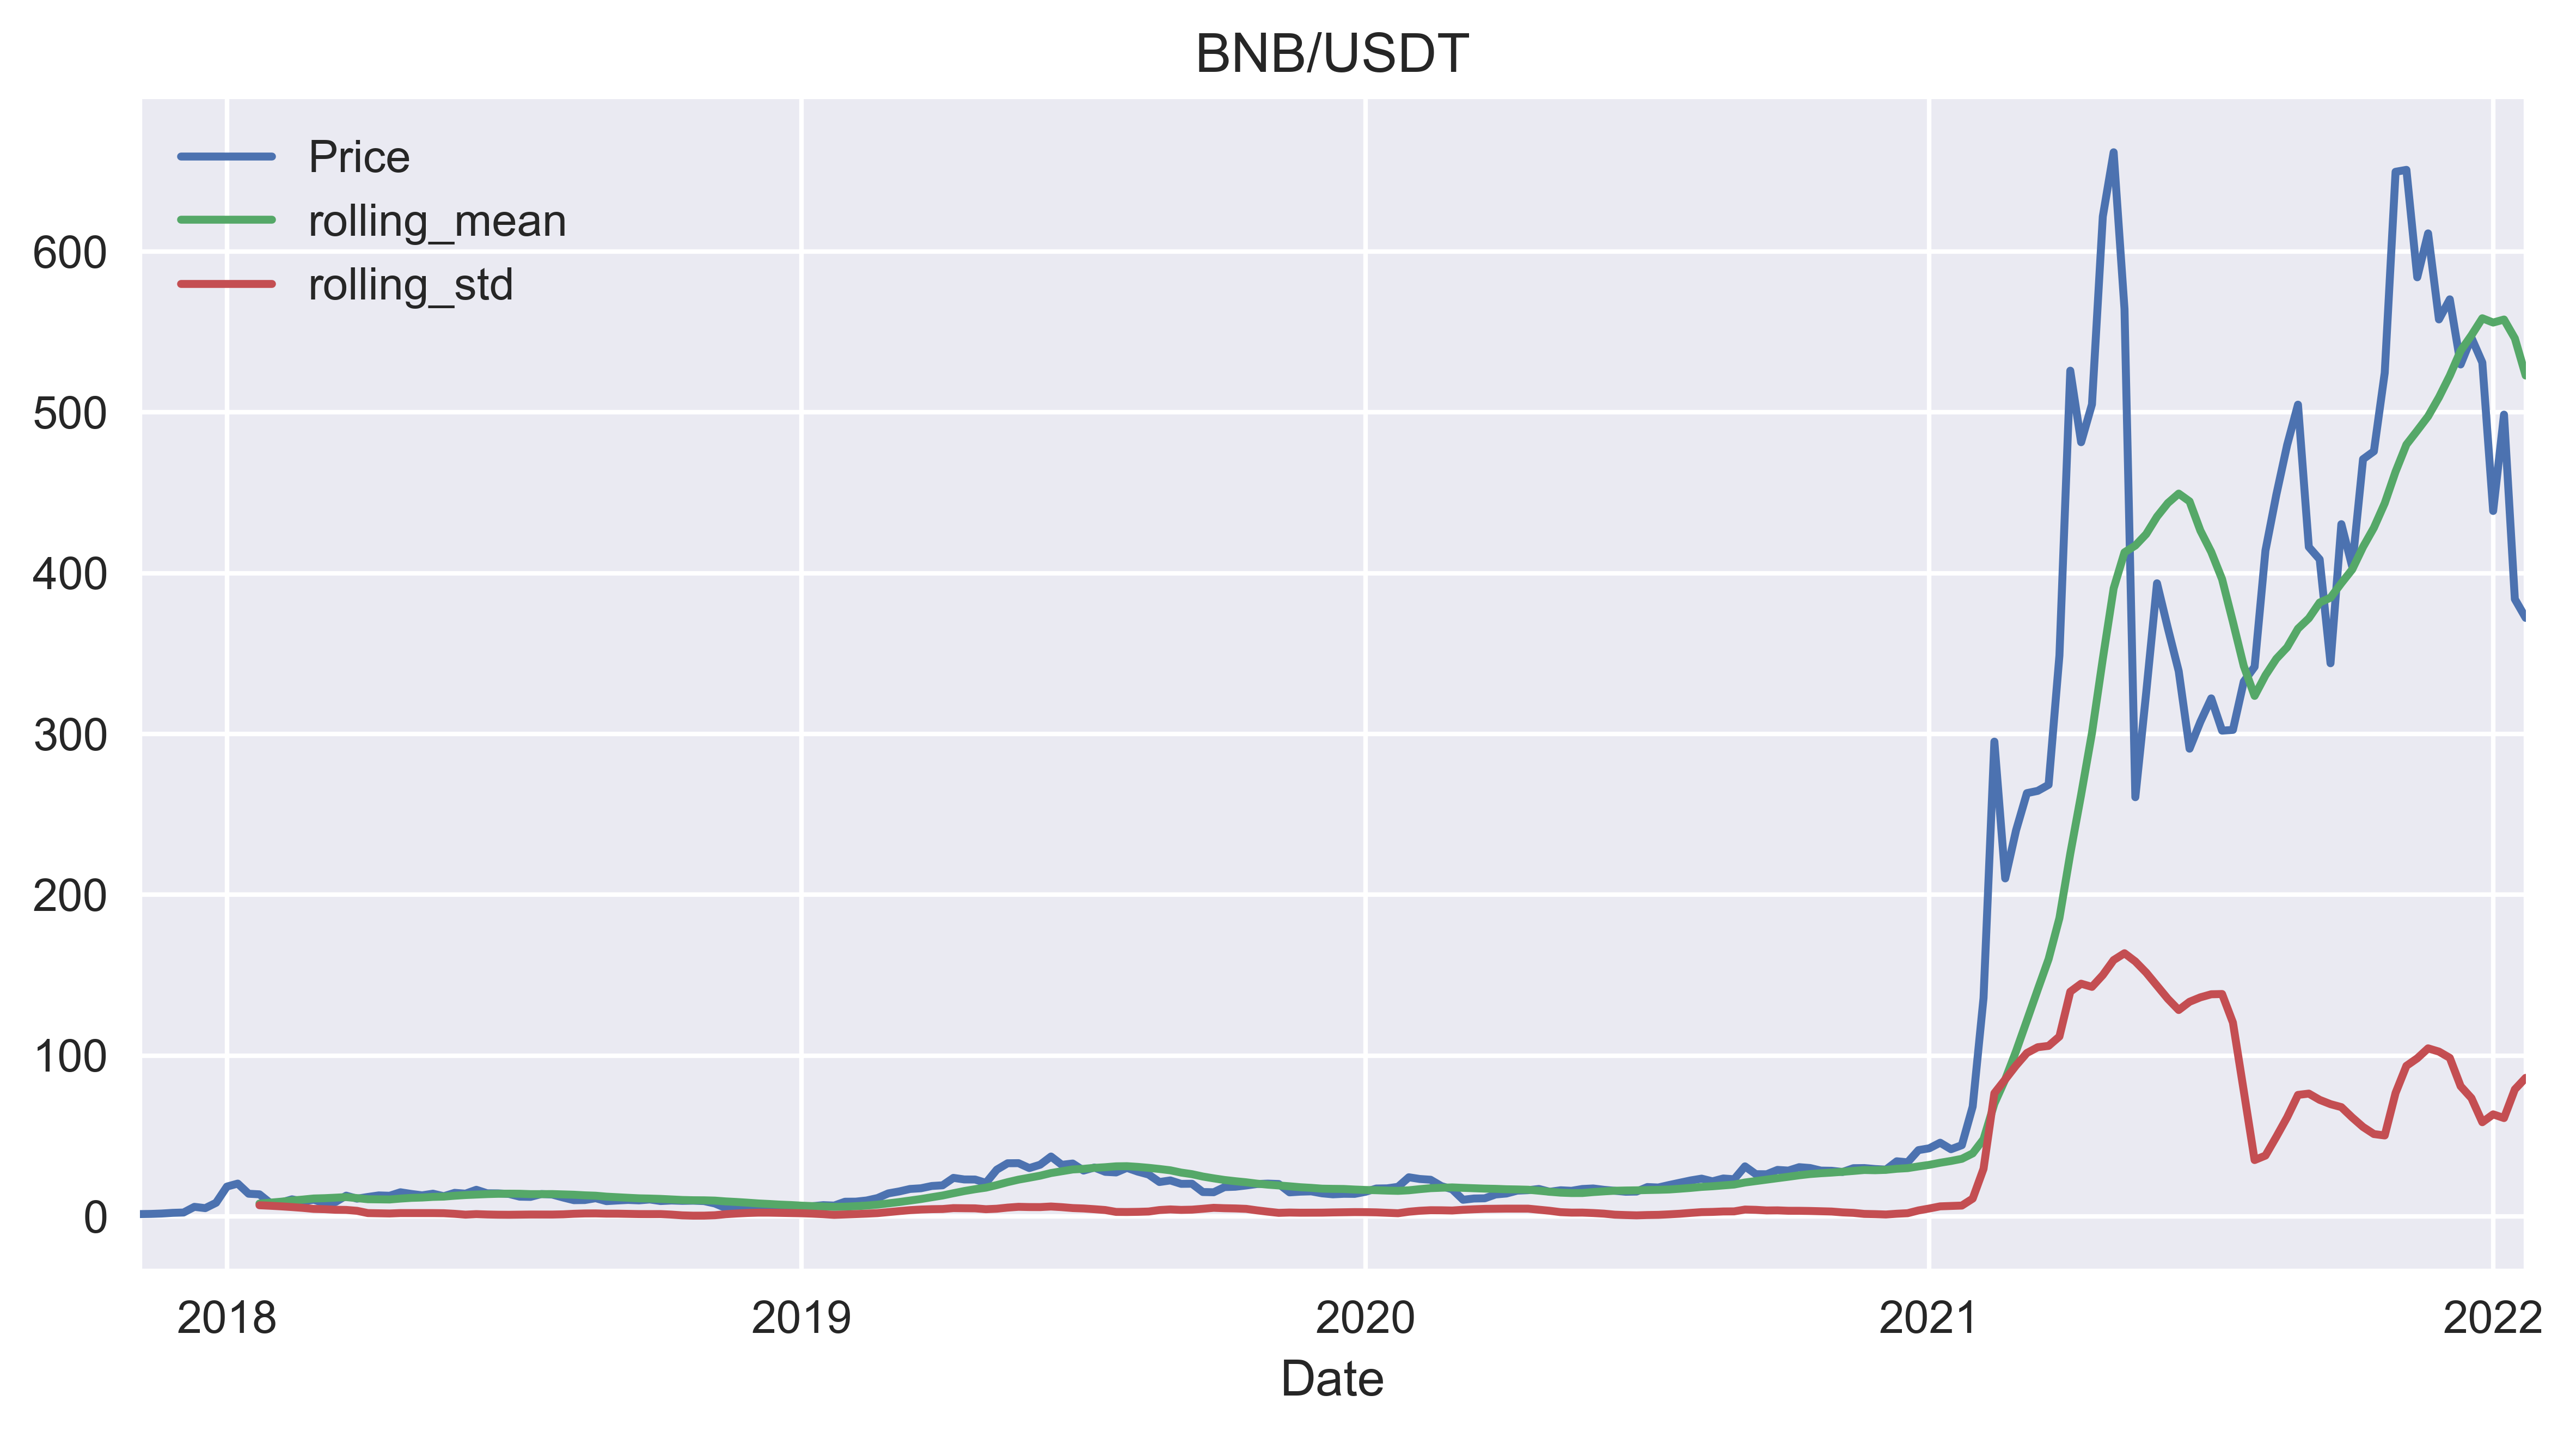

In [10]:
WINDOW_SIZE = 12
df['rolling_mean'] = df.Price.rolling(window=WINDOW_SIZE).mean()
df['rolling_std'] = df.Price.rolling(window=WINDOW_SIZE).std()
df.plot(title='BNB/USDT')

plt.tight_layout()
plt.show()

Phân rã dữ liệu theo mua bằng cách sử dụng mô hình tổng hợp (multiplicative model):

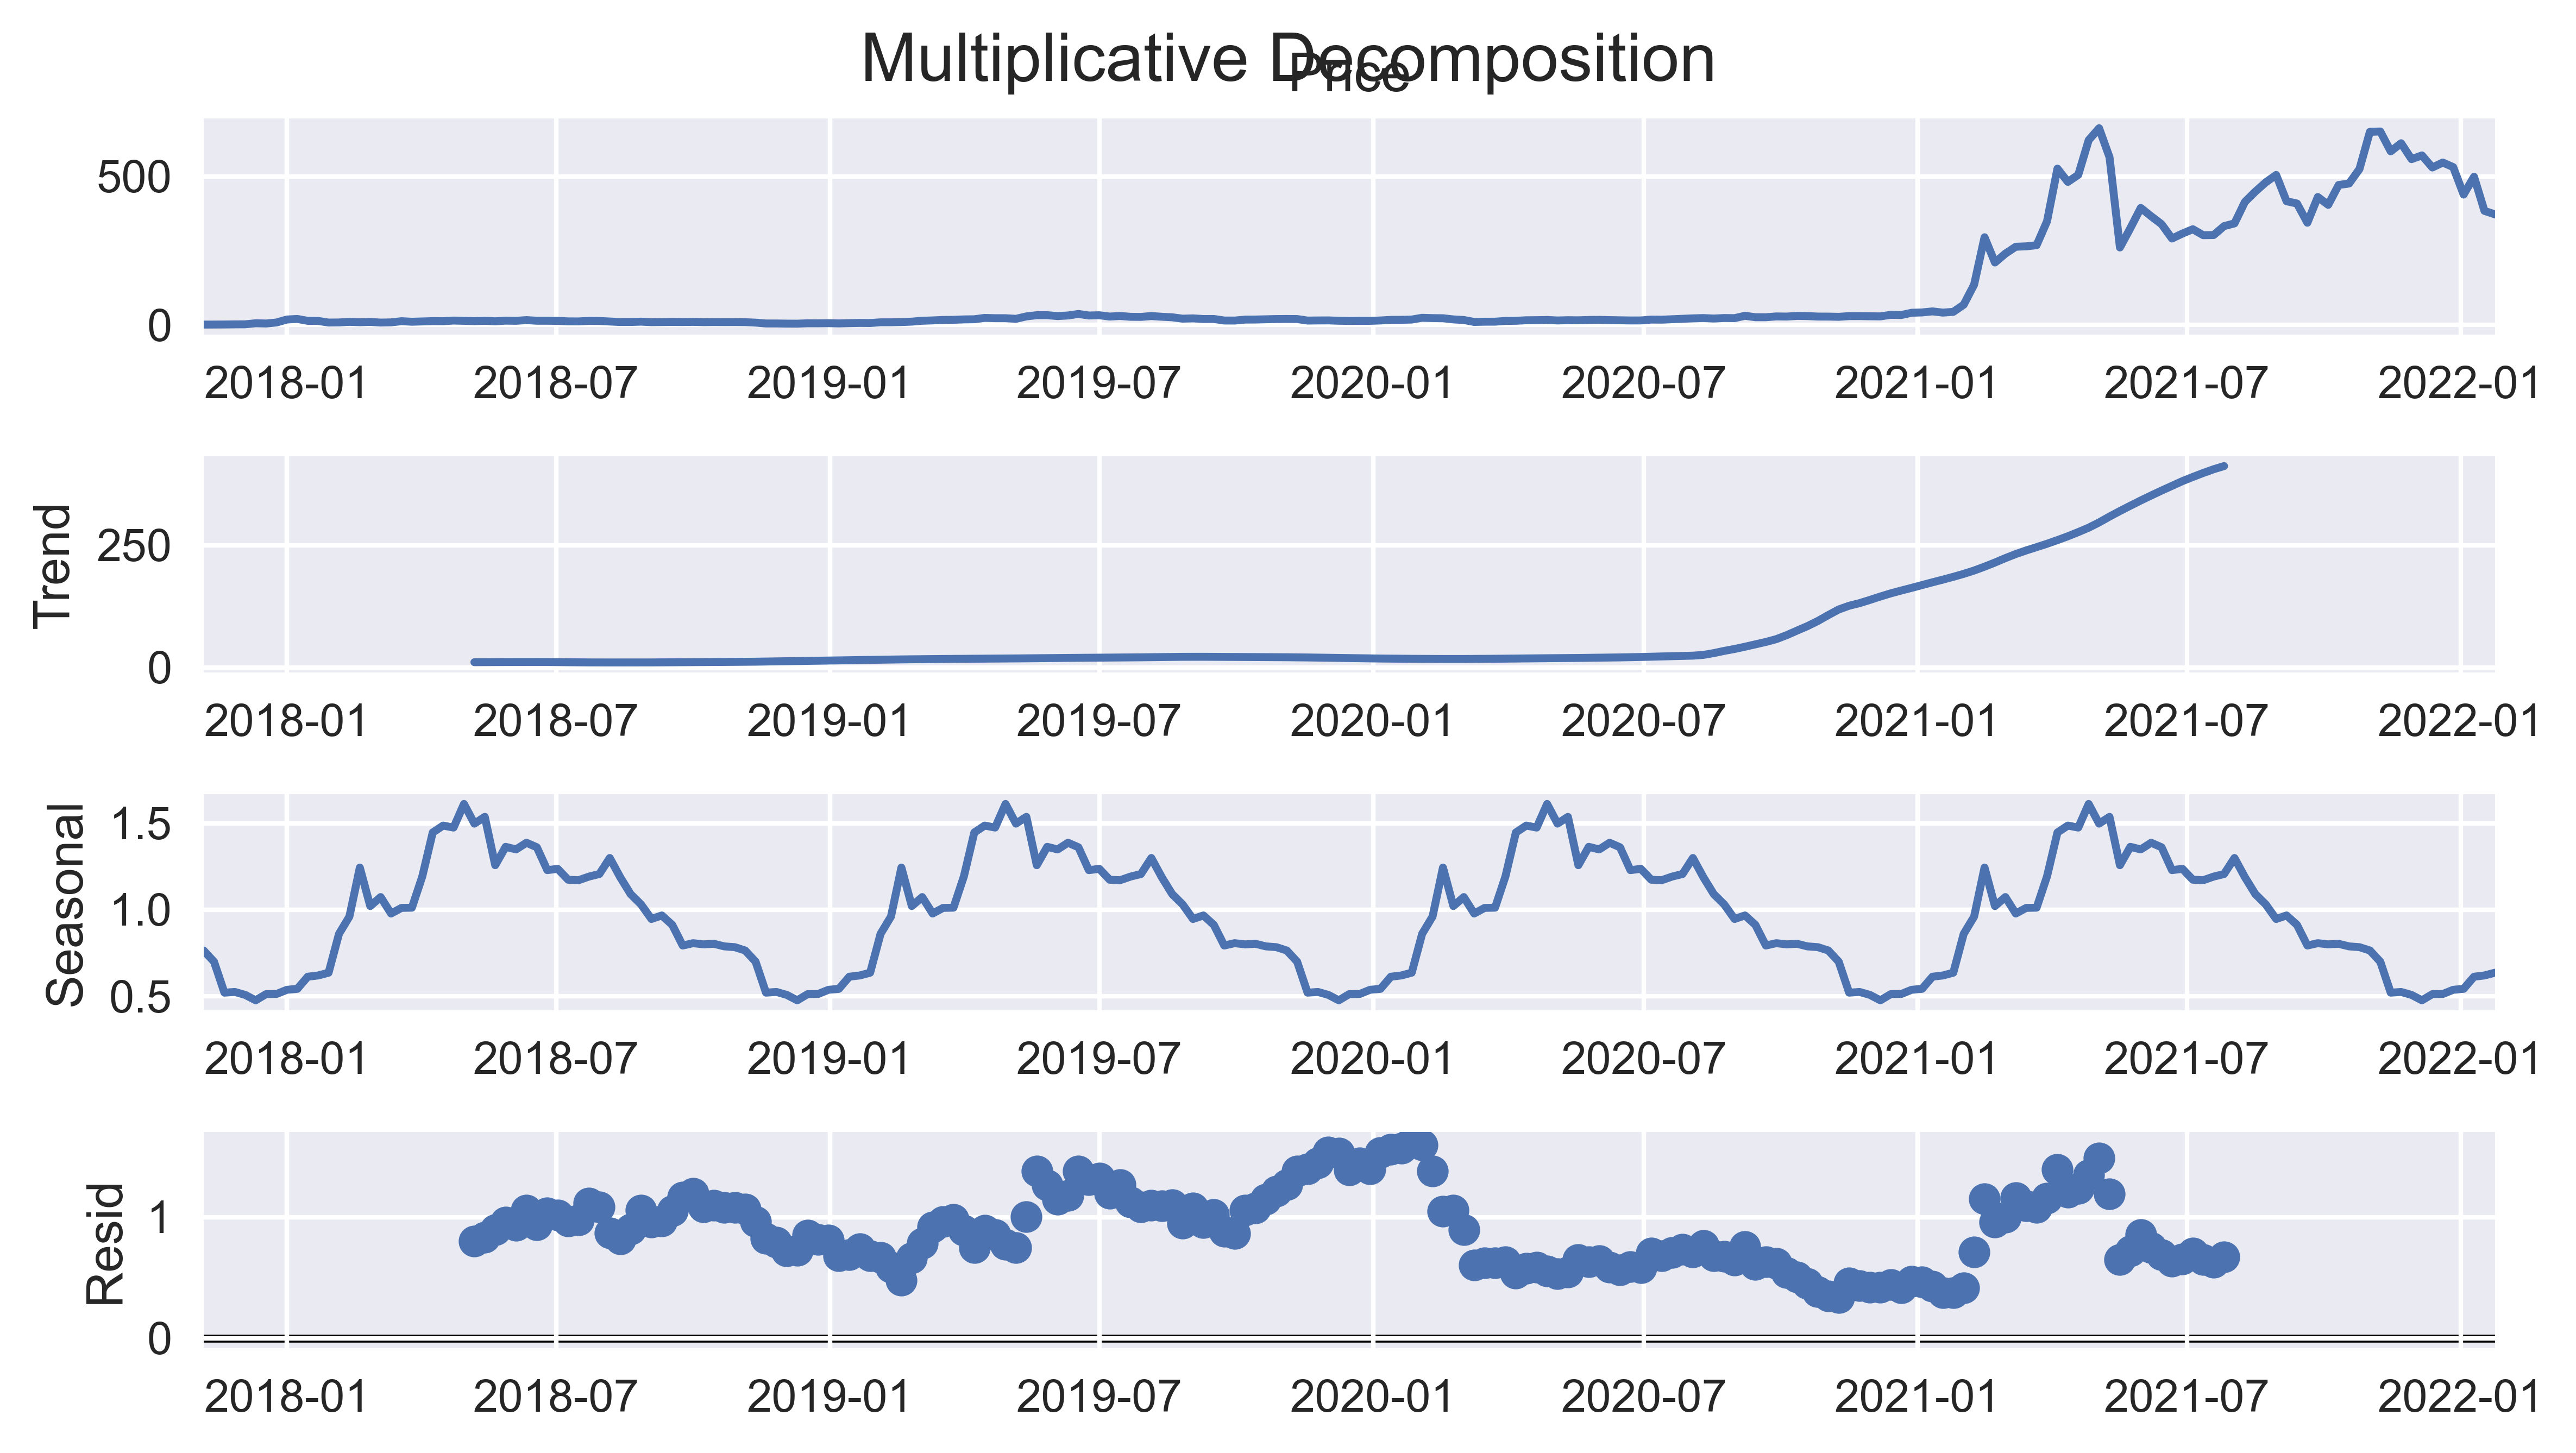

In [13]:
decomposition_results = seasonal_decompose(df.Price, 
                                           model='multiplicative')
decomposition_results.plot() \
                     .suptitle('Multiplicative Decomposition', 
                               fontsize=15)

plt.tight_layout()
plt.show()

# ARIMA

In [14]:
#pip install pmdarima

In [15]:
import pmdarima as pm
from pmdarima.arima import ndiffs, nsdiffs
import pandas as pd
import numpy as np
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox
import scipy.stats as scs
import matplotlib.pyplot as plt

In [16]:
print(f"Suggested # of differences (ADF): {ndiffs(df.Price, test='adf')}")
print(f"Suggested # of differences (KPSS): {ndiffs(df.Price, test='kpss')}")
print(f"Suggested # of differences (PP): {ndiffs(df.Price, test='pp')}")

Suggested # of differences (ADF): 1
Suggested # of differences (KPSS): 1
Suggested # of differences (PP): 1


In [17]:
print(f"Suggested # of differences (OSCB): {nsdiffs(df.Price, m=12, test='ocsb')}")
print(f"Suggested # of differences (CH): {nsdiffs(df.Price, m=12, test='ch')}")

Suggested # of differences (OSCB): 0
Suggested # of differences (CH): 0


In [18]:
df = df['Price']

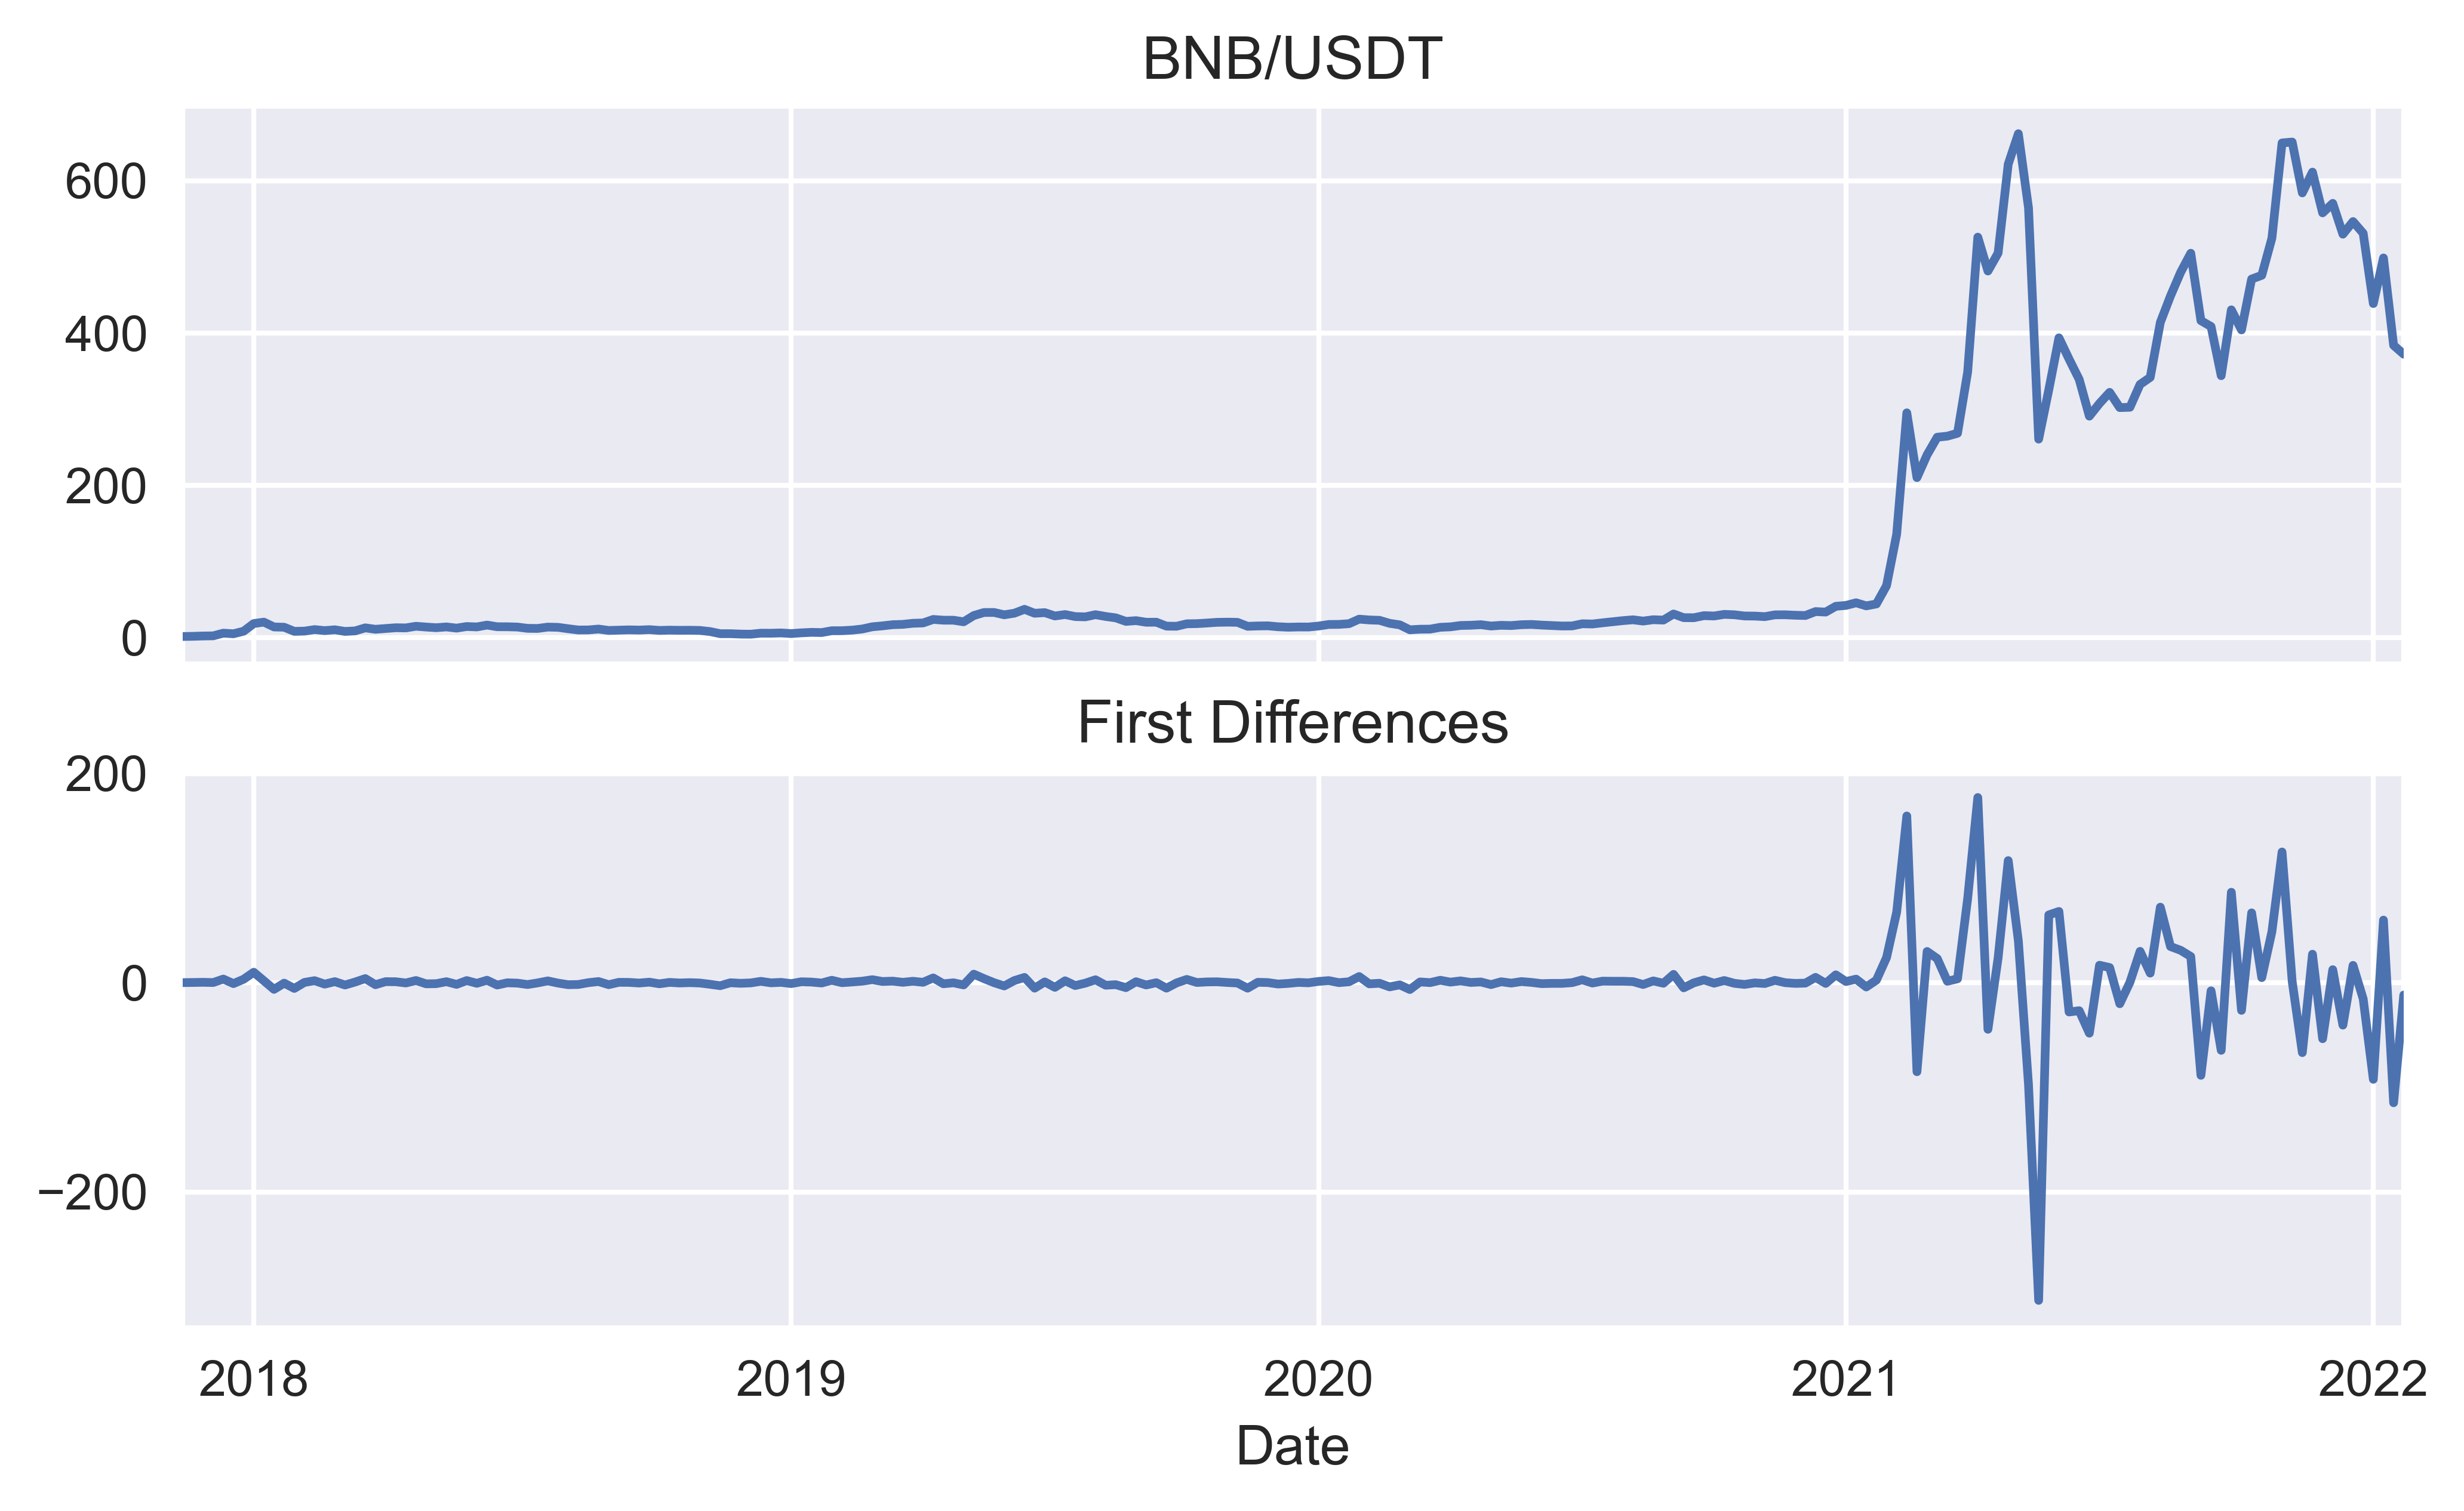

In [19]:
NEO_diff = df.diff().dropna()

fig, ax = plt.subplots(2, sharex=True)
df.plot(title = "BNB/USDT", ax=ax[0])
NEO_diff.plot(ax=ax[1], title='First Differences')

In [20]:
# import libraries 
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tools.sm_exceptions import InterpolationWarning
import warnings

# settings 
warnings.filterwarnings('ignore', '.*output shape of zoom.*')
warnings.simplefilter(action='ignore', category=InterpolationWarning)
plt.style.use('seaborn')

def adf_test(x):
    '''
    Function for performing the Augmented Dickey-Fuller test for stationarity
    
    Null Hypothesis: time series is not stationary
    Alternate Hypothesis: time series is stationary

    Parameters
    ----------
    x : pd.Series / np.array
        The time series to be checked for stationarity
    
    Returns
    -------
    results: pd.DataFrame
        A DataFrame with the ADF test's results
    '''

    indices = ['Test Statistic', 'p-value',
               '# of Lags Used', '# of Observations Used']

    adf_test = adfuller(x, autolag='AIC')
    results = pd.Series(adf_test[0:4], index=indices)

    for key, value in adf_test[4].items():
        results[f'Critical Value ({key})'] = value

    return results


def kpss_test(x, h0_type='c'):
    '''
    Function for performing the Kwiatkowski-Phillips-Schmidt-Shin test for stationarity

    Null Hypothesis: time series is stationary
    Alternate Hypothesis: time series is not stationary

    Parameters
    ----------
    x: pd.Series / np.array
        The time series to be checked for stationarity
    h0_type: str{'c', 'ct'}
        Indicates the null hypothesis of the KPSS test:
            * 'c': The data is stationary around a constant(default)
            * 'ct': The data is stationary around a trend
    
    Returns
    -------
    results: pd.DataFrame
        A DataFrame with the KPSS test's results
    '''

    indices = ['Test Statistic', 'p-value', '# of Lags']

    kpss_test = kpss(x, regression=h0_type)
    results = pd.Series(kpss_test[0:3], index=indices)

    for key, value in kpss_test[3].items():
        results[f'Critical Value ({key})'] = value

    return results


def test_autocorrelation(x, n_lags=40, alpha=0.05, h0_type='c'):
    '''
    Function for testing the stationarity of a series by using:
    * the ADF test
    * the KPSS test
    * ACF/PACF plots

    Parameters
    ----------
    x: pd.Series / np.array
        The time series to be checked for stationarity
    n_lags : int
        The number of lags for the ACF/PACF plots
    alpha : float
        Significance level for the ACF/PACF plots
    h0_type: str{'c', 'ct'}
        Indicates the null hypothesis of the KPSS test:
            * 'c': The data is stationary around a constant(default)
            * 'ct': The data is stationary around a trend

    Returns
    -------
    fig : matplotlib.figure.Figure
        Figure containing the ACF/PACF plot
    '''

    adf_results = adf_test(x)
    kpss_results = kpss_test(x, h0_type=h0_type)

    print('ADF test statistic: {:.2f} (p-val: {:.2f})'.format(adf_results['Test Statistic'],
                                                             adf_results['p-value']))
    print('KPSS test statistic: {:.2f} (p-val: {:.2f})'.format(kpss_results['Test Statistic'],
                                                              kpss_results['p-value']))

    fig, ax = plt.subplots(2, figsize=(16, 8))
    plot_acf(x, ax=ax[0], lags=n_lags, alpha=alpha)
    plot_pacf(x, ax=ax[1], lags=n_lags, alpha=alpha)

    return fig

ADF test statistic: -5.28 (p-val: 0.00)
KPSS test statistic: 0.11 (p-val: 0.10)


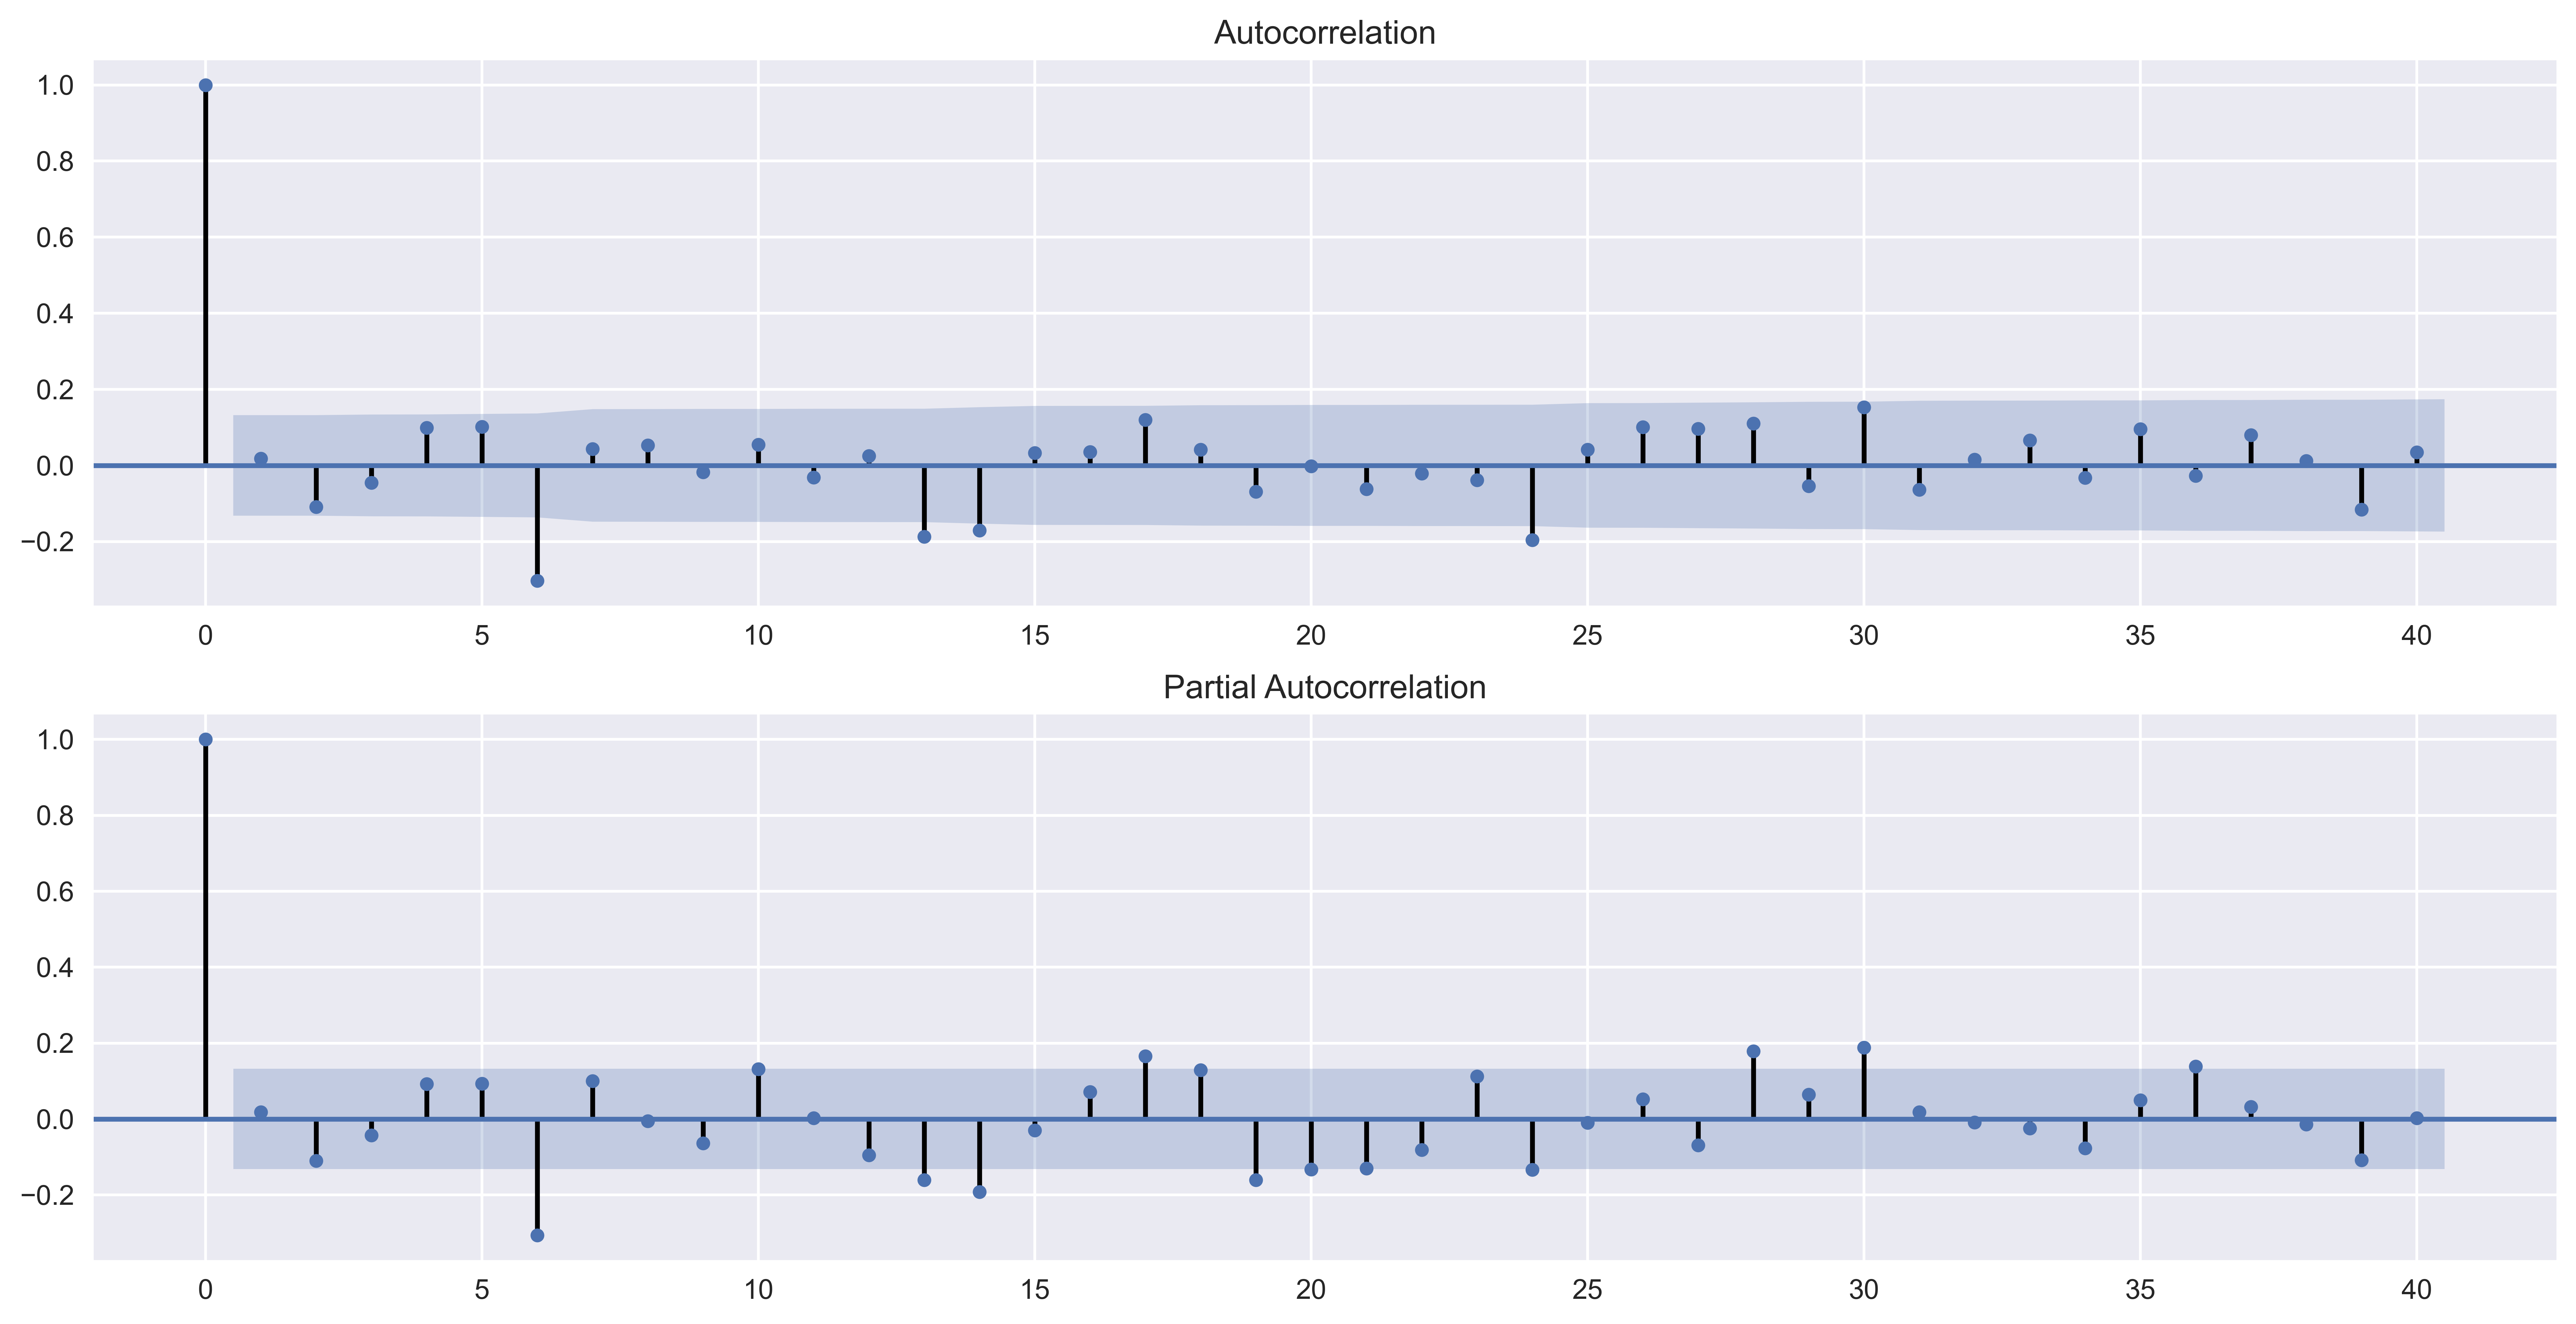

In [21]:
fig = test_autocorrelation(NEO_diff)

In [22]:
from pmdarima import auto_arima
model= auto_arima(NEO_diff, trace=True,
suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=2209.813, Time=0.42 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=2214.756, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=2216.683, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=2216.663, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=2213.217, Time=0.01 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=2218.216, Time=0.14 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=2217.819, Time=0.16 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.36 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.23 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=2216.055, Time=0.18 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=2218.812, Time=0.21 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=2219.363, Time=0.20 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=2205.216, Time=0.39 sec
 ARIMA(4,0,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.44 sec
 ARIMA(3,0,4)(0,0,0)[0] intercept   : AIC=inf, T

In [23]:
print(model.aic())

2189.2852422592887


In [24]:
train=NEO_diff.iloc[:-20]
test=NEO_diff.iloc[-20:]

In [25]:
len(test)

20

In [26]:
len(train)

200

In [27]:
model.fit(train)

ARIMA(order=(5, 0, 2), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [28]:
forecast = model.predict(n_periods=len(test))

In [29]:
forecast

array([ -4.04206083,  13.74158287,  12.63890611,  -9.98357547,
       -25.55964189,  24.30777145,  -5.03466533,   1.72112318,
        -6.41846702,  -1.71535515,  11.39881516, -10.06212725,
         4.87192139,  -3.7731164 ,   2.44020791,   2.04640779,
        -5.33045023,   4.99053059,  -3.63598905,   2.70699756])

In [30]:
forecast = pd.DataFrame(forecast, index = test.index, columns = ['Prediction'])

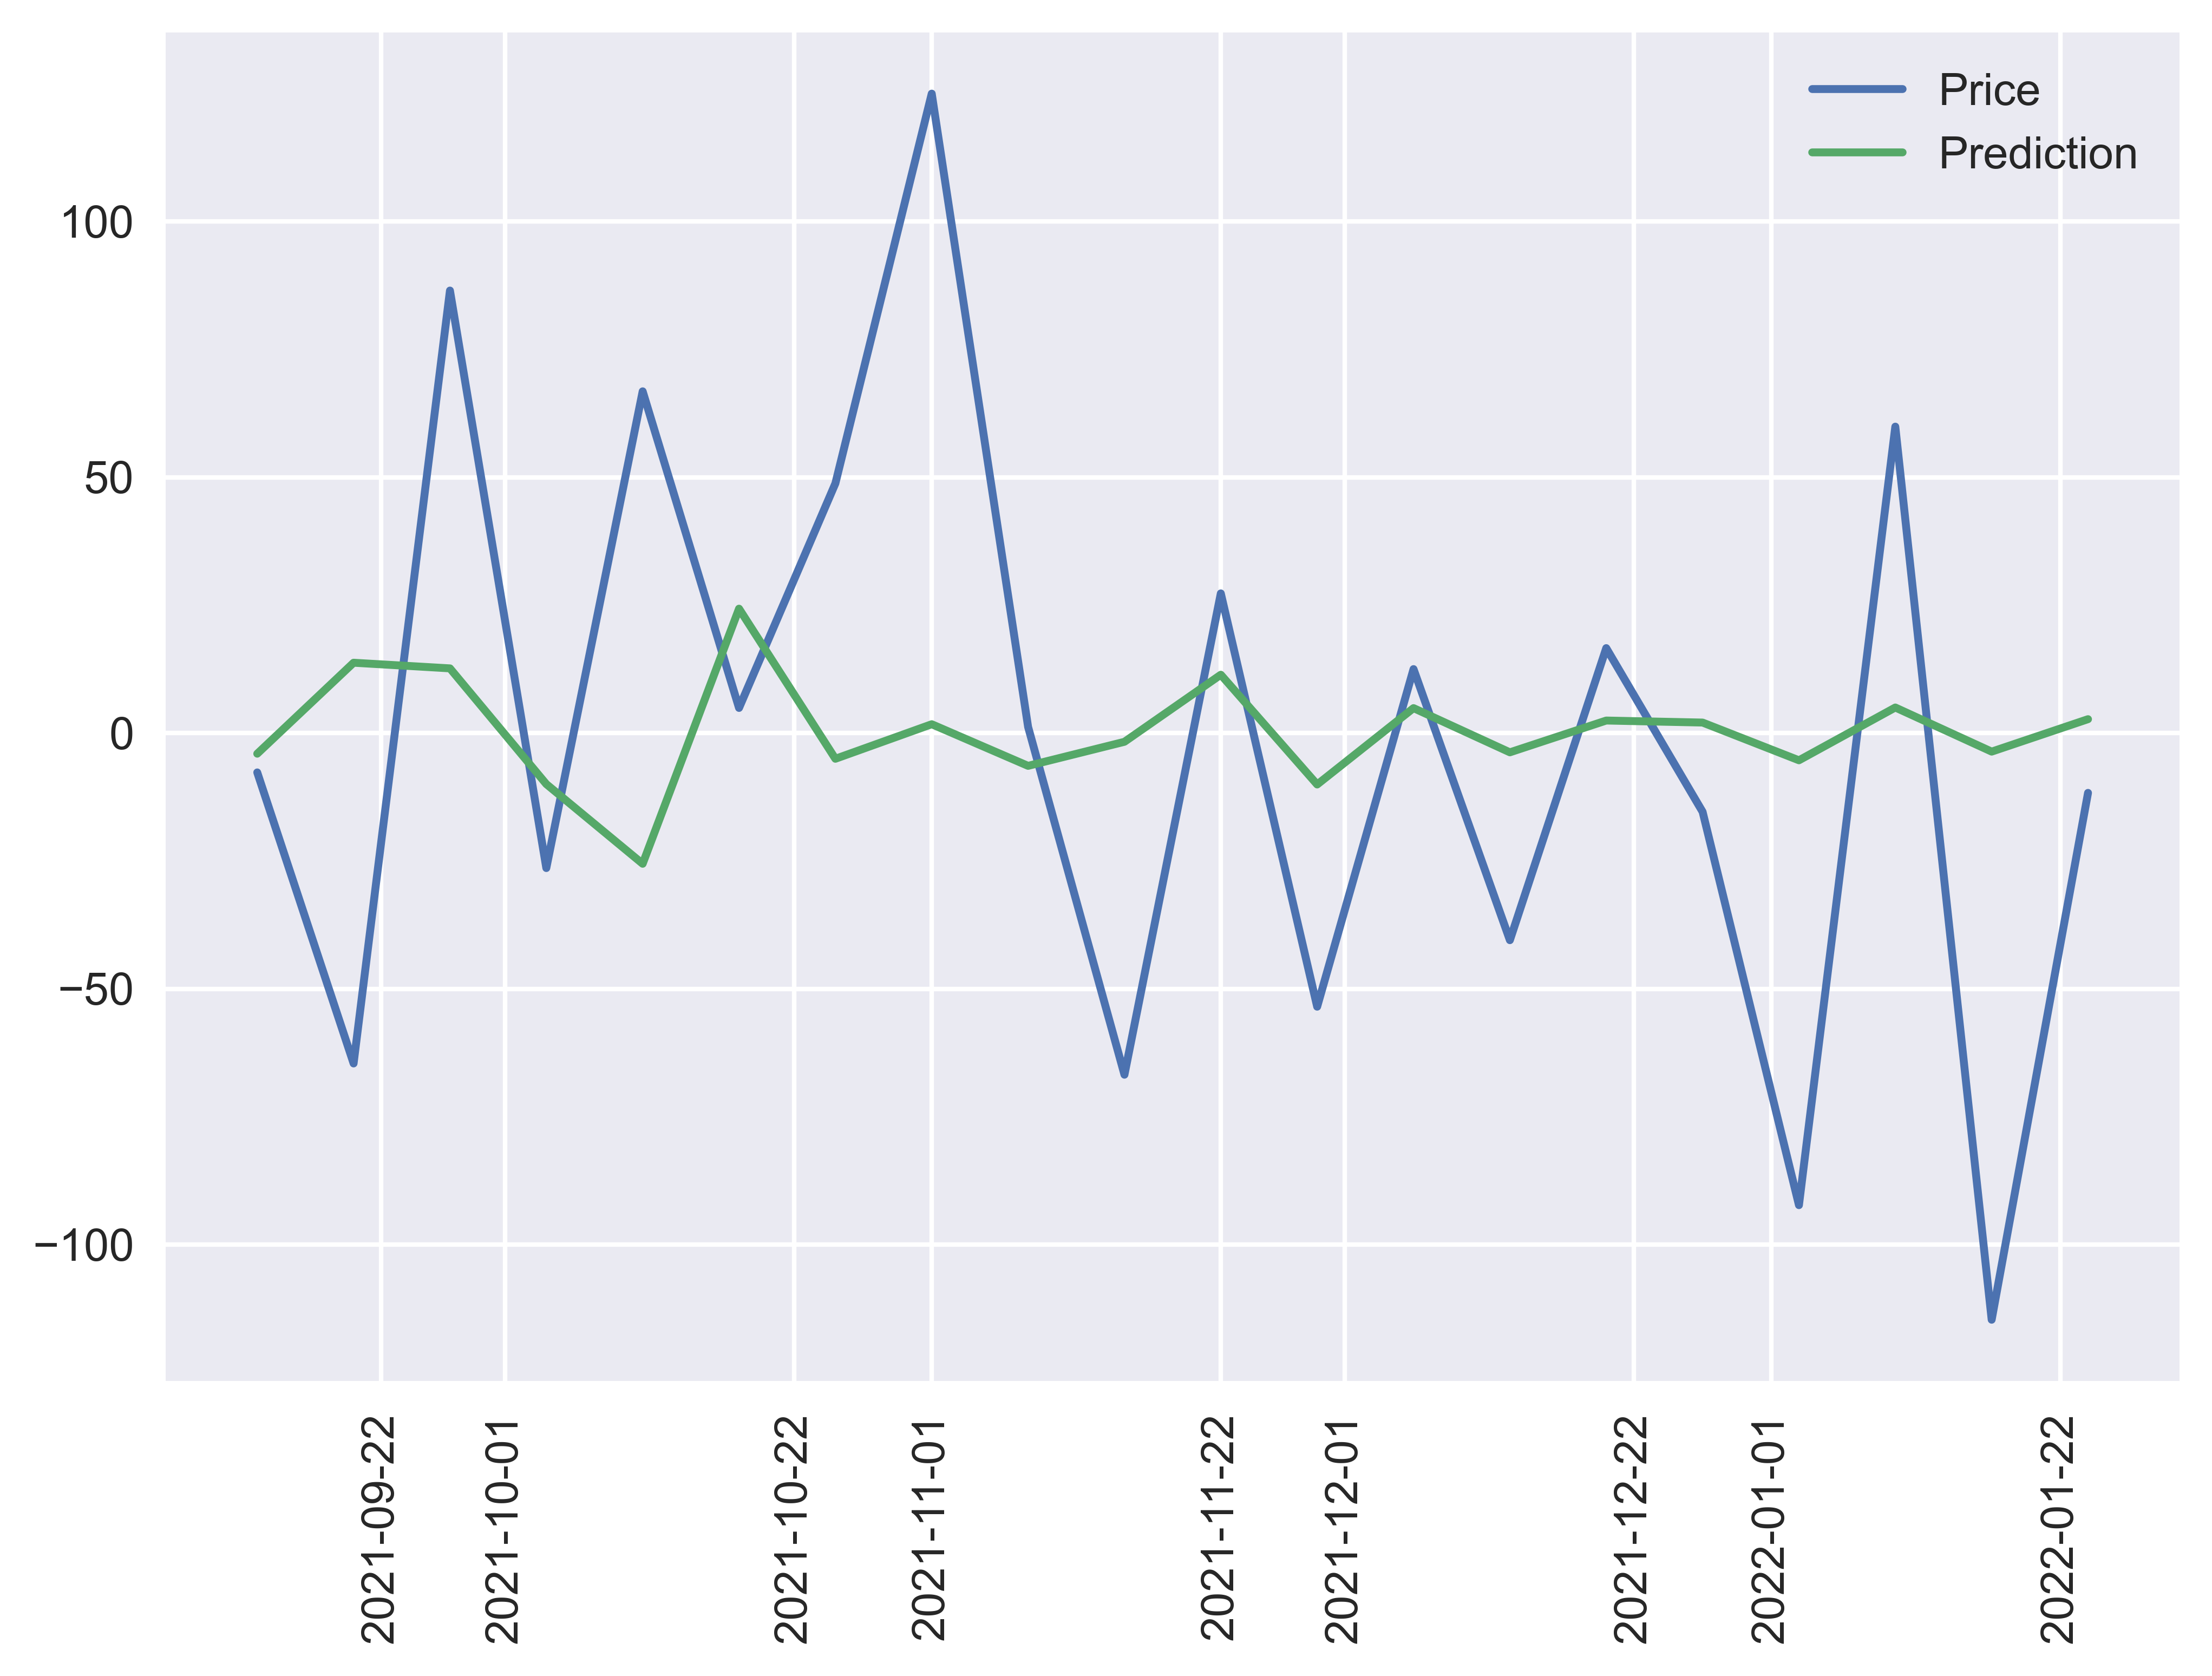

In [31]:
plt.plot(test, label='Price')
plt.plot(forecast, label='Prediction')
plt.xticks(rotation='vertical')
plt.legend()
plt.show()

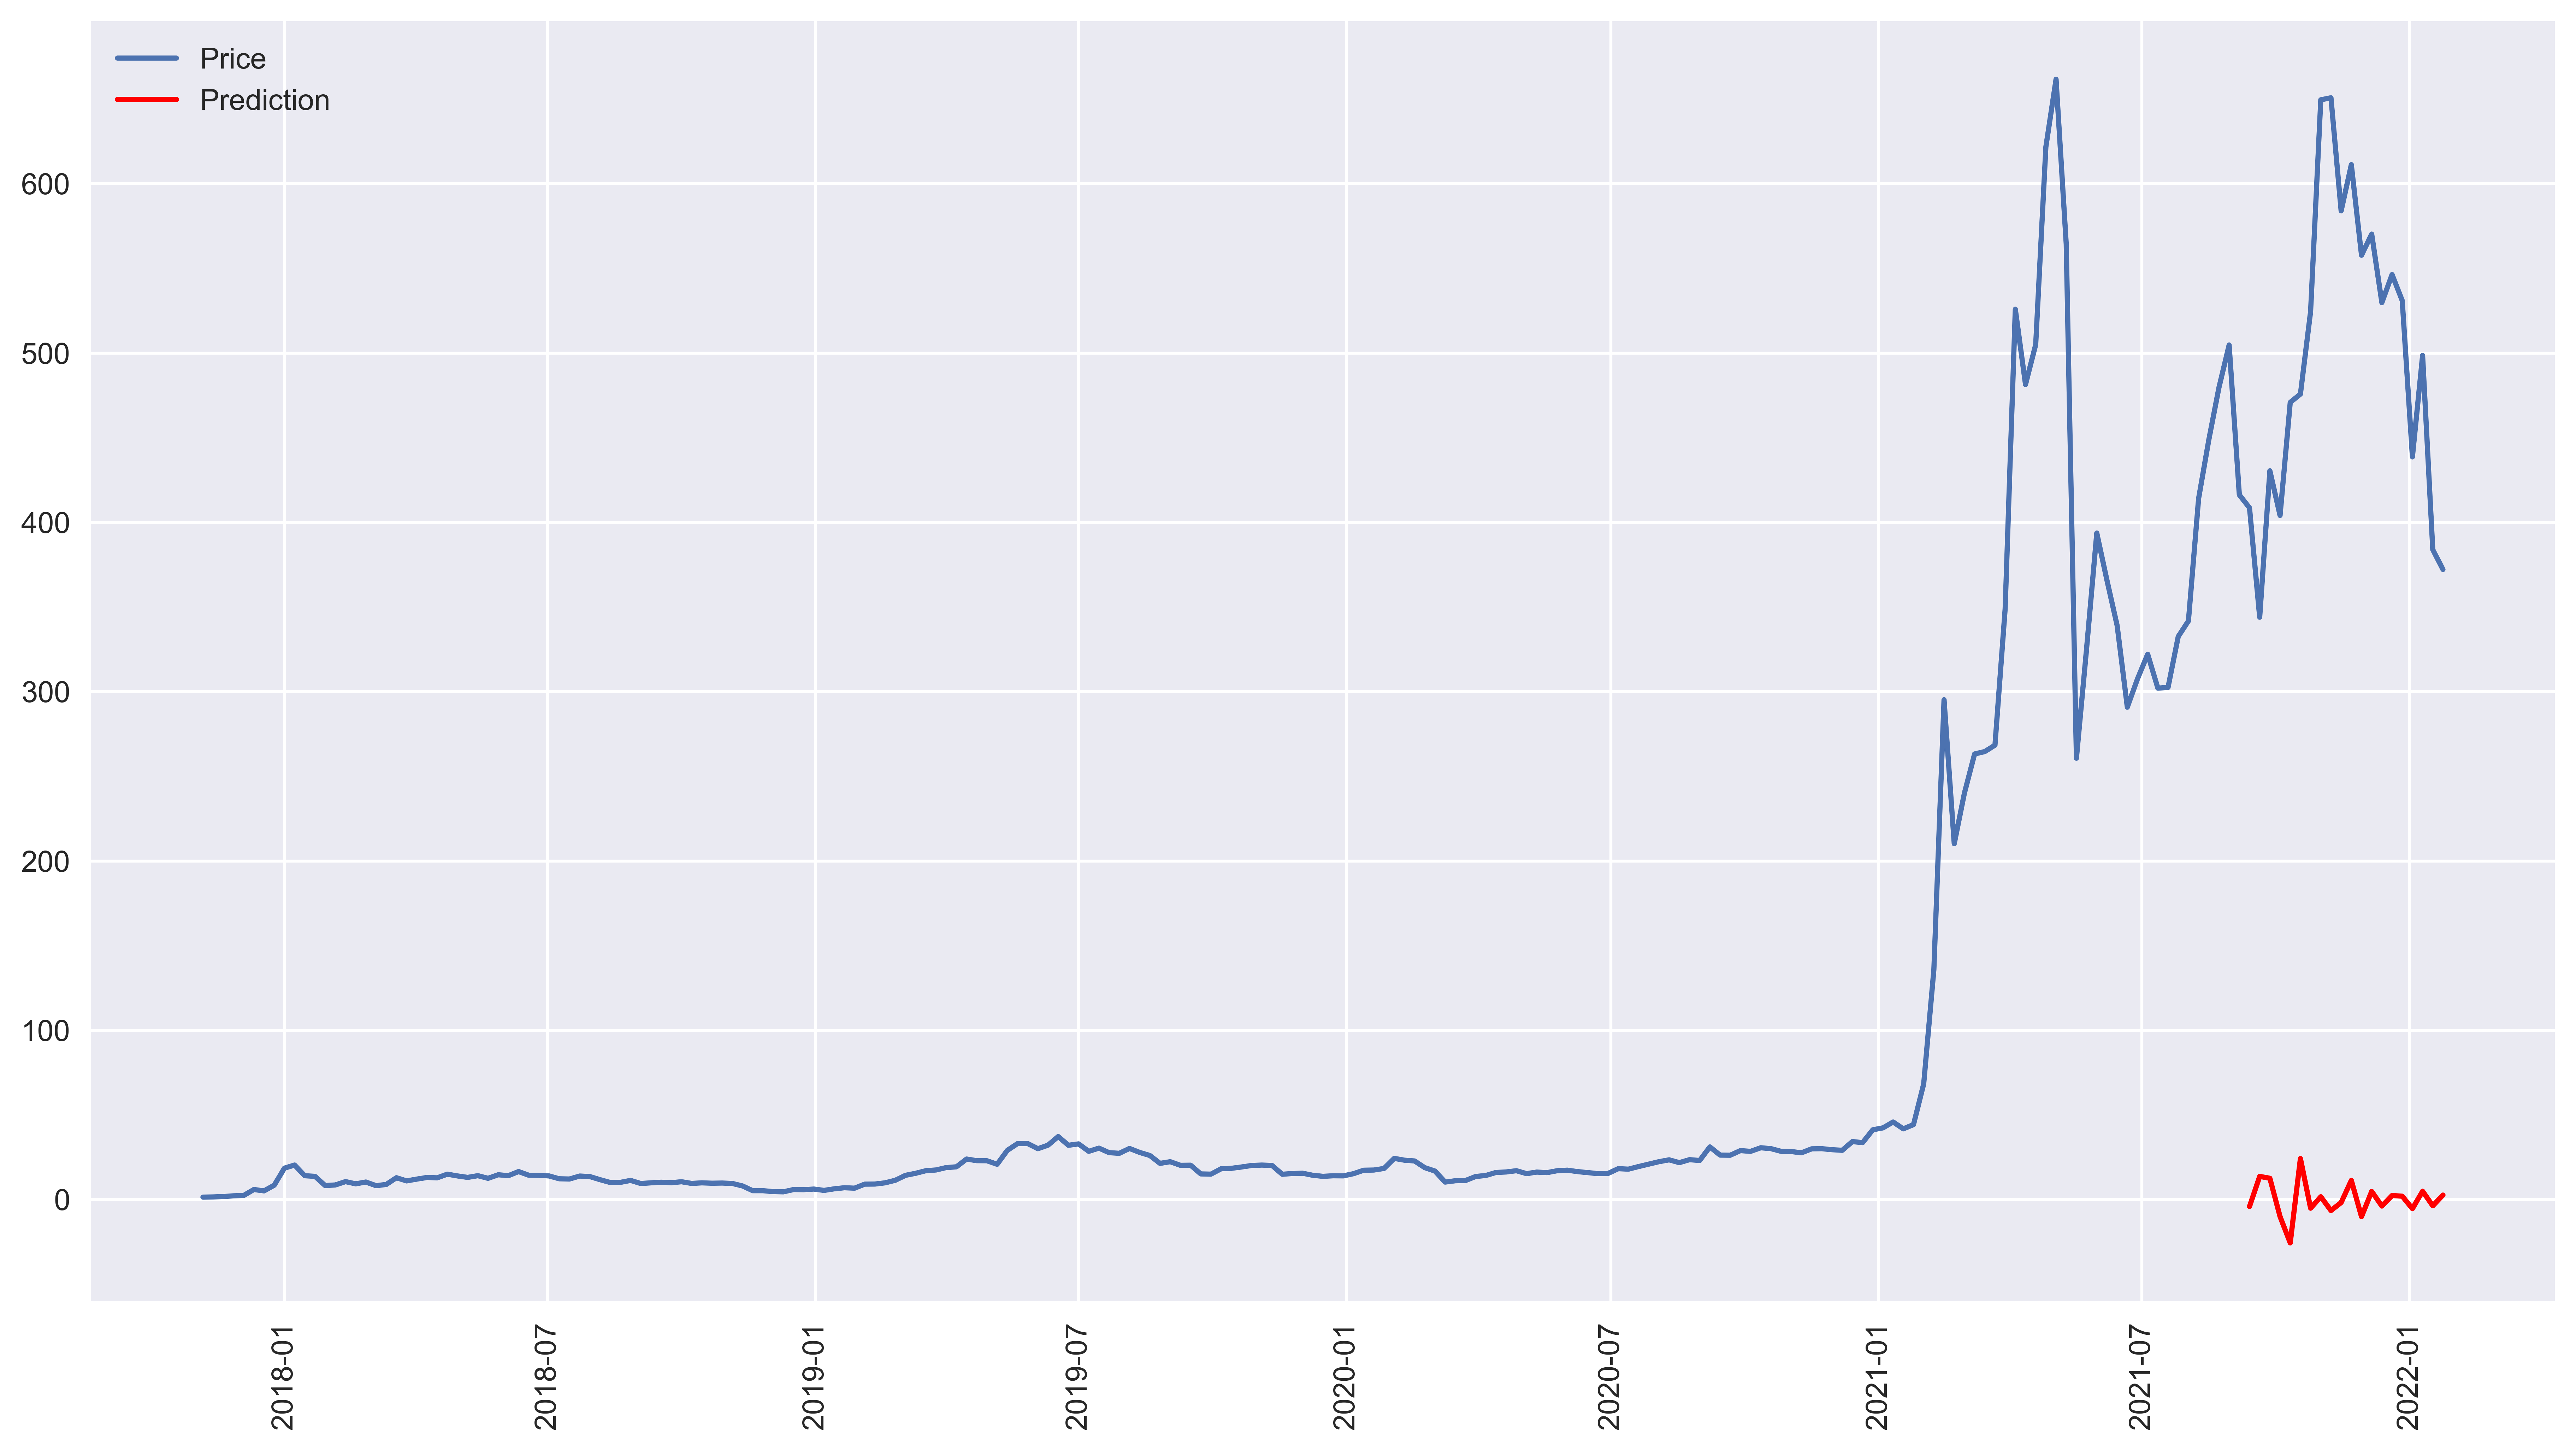

In [32]:
plt.figure(figsize=(15,8))
plt.plot(df, label = 'Price')
plt.plot(forecast, label = 'Prediction', color = 'red')
plt.xticks(rotation= 'vertical')
plt.legend()
plt.show()

Dự báo sự biến động trong 3 tháng tiếp theo

In [39]:
forecast = model.predict(n_periods=len(test)+4)
forecast

array([ -4.04206083,  13.74158287,  12.63890611,  -9.98357547,
       -25.55964189,  24.30777145,  -5.03466533,   1.72112318,
        -6.41846702,  -1.71535515,  11.39881516, -10.06212725,
         4.87192139,  -3.7731164 ,   2.44020791,   2.04640779,
        -5.33045023,   4.99053059,  -3.63598905,   2.70699756,
        -1.06987194,  -1.21627111,   2.6236067 ,  -2.75442424])

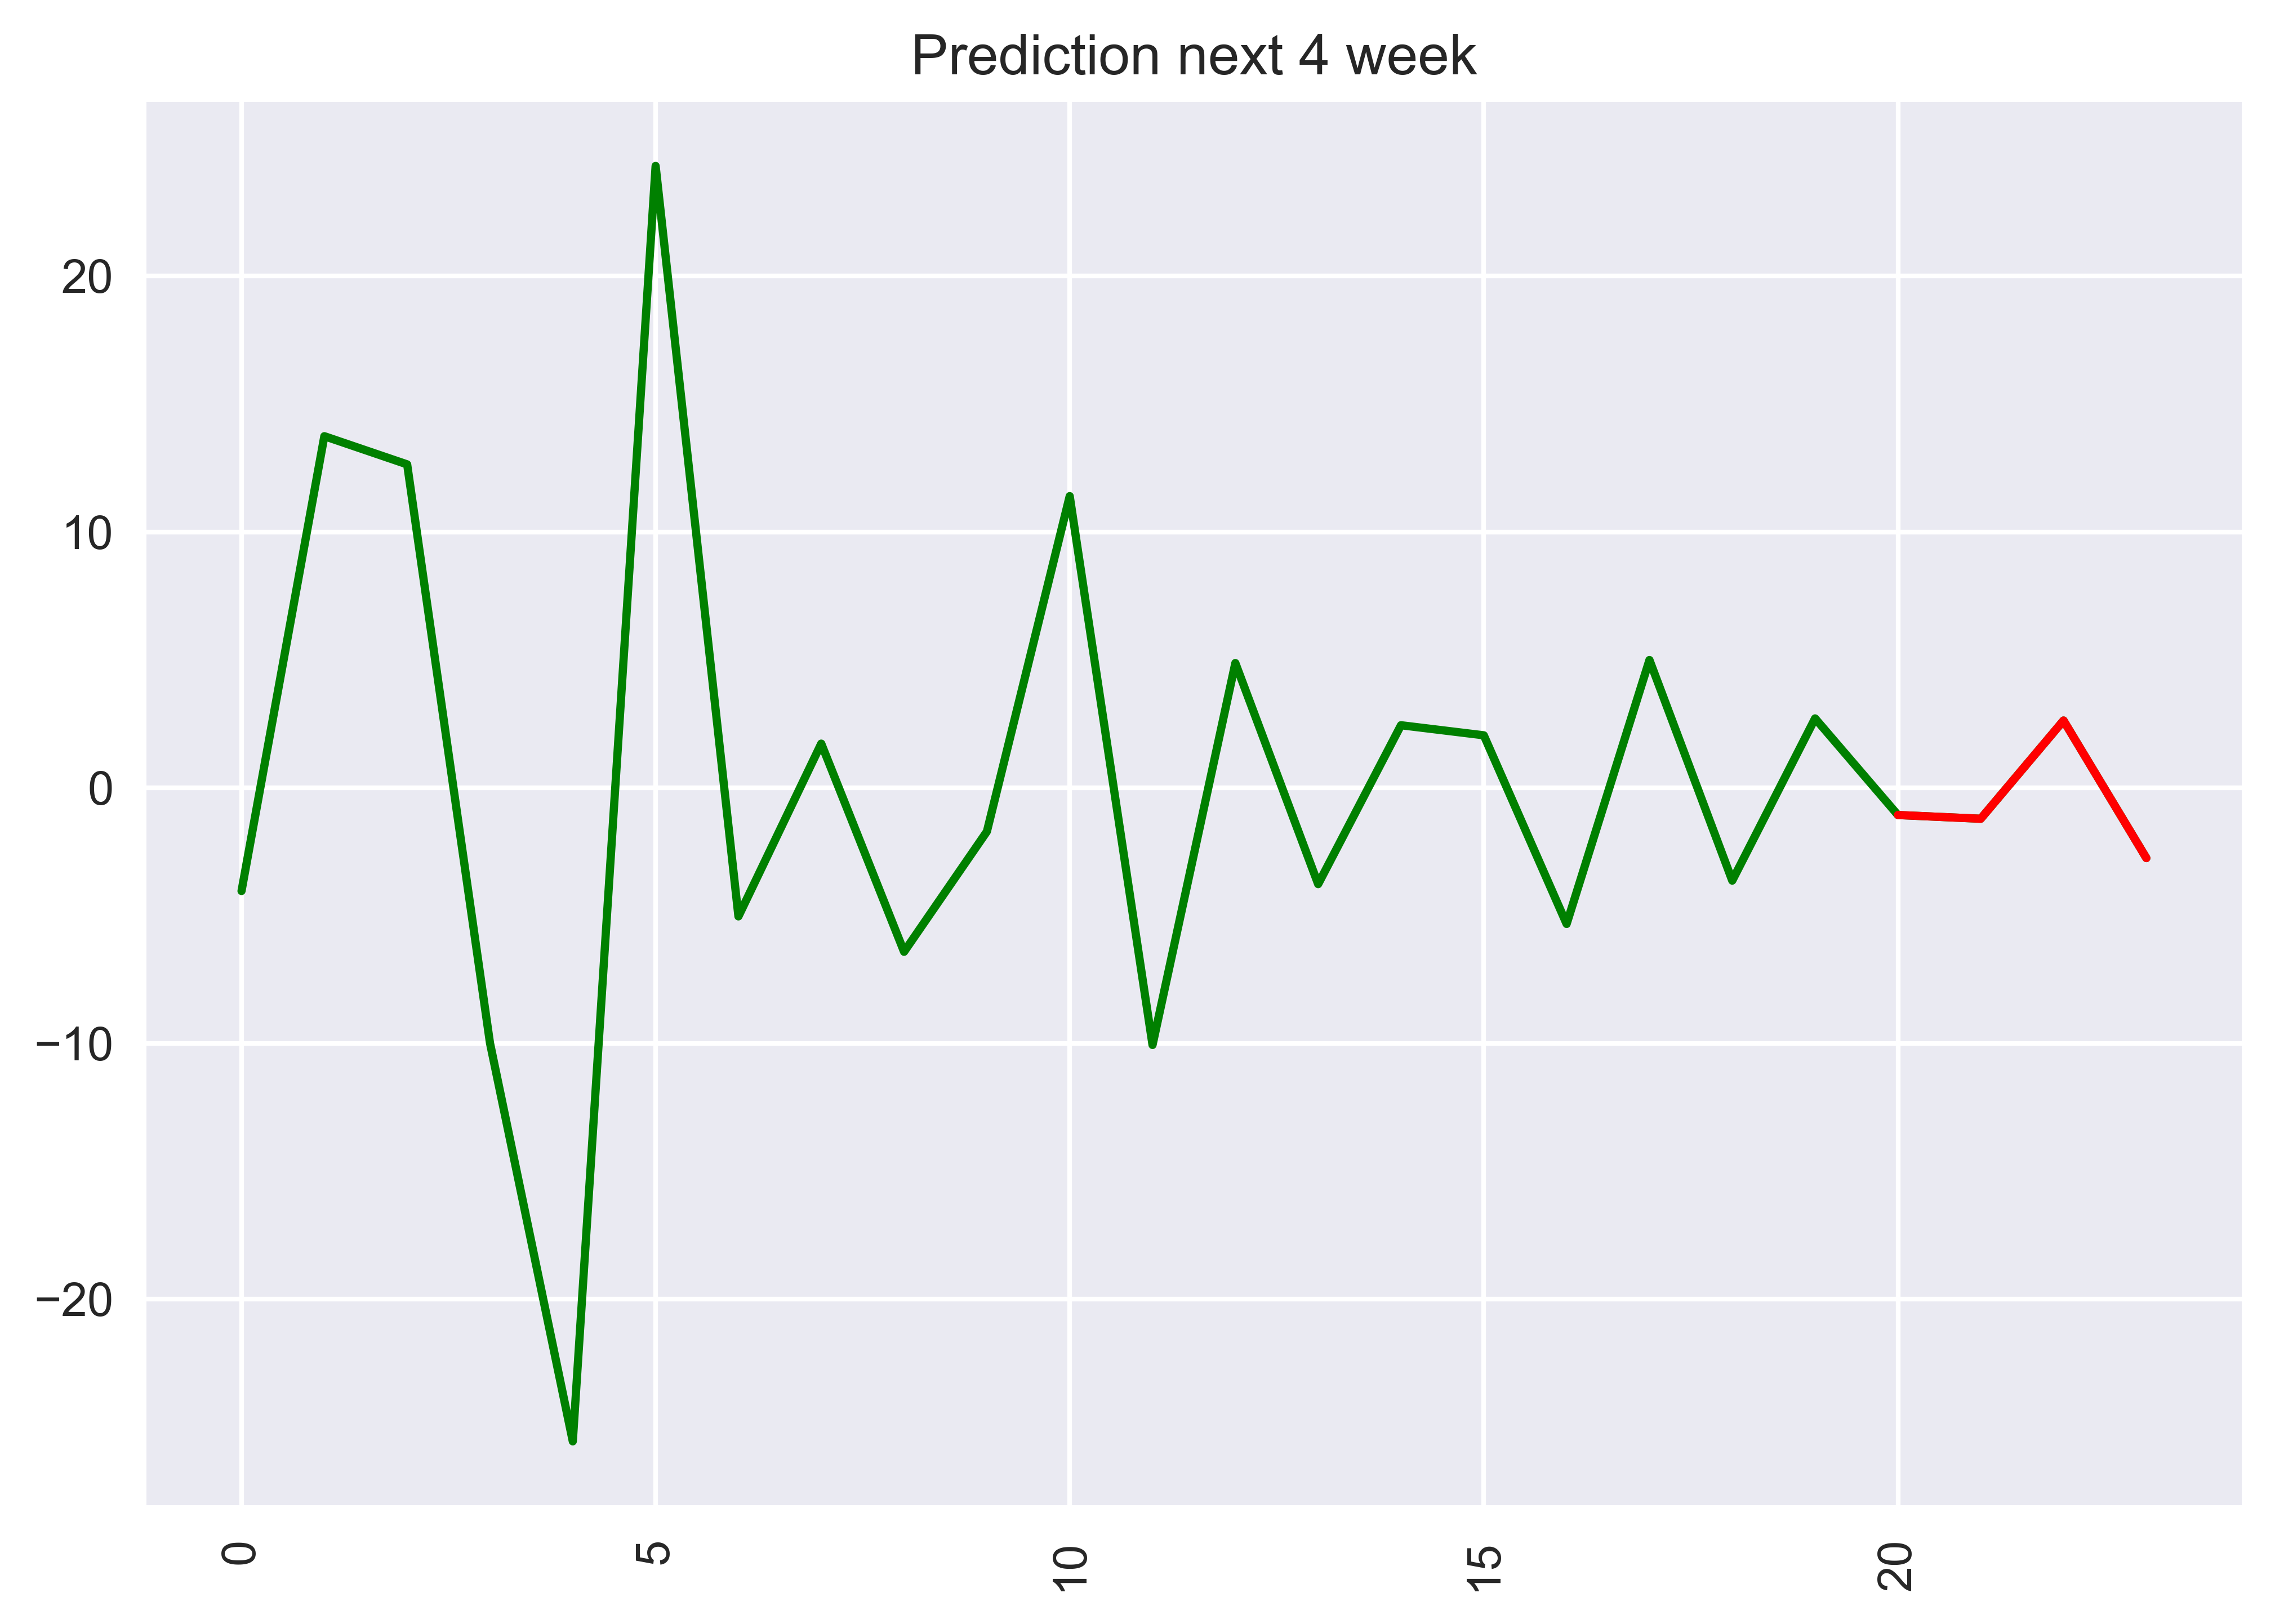

In [40]:
plt.plot(np.arange(24), forecast, color='green')
plt.plot(np.array([20,21,22,23]), forecast[len(test):], color='red')
plt.xticks(rotation='vertical')
plt.title('Prediction next 4 week')
plt.show()

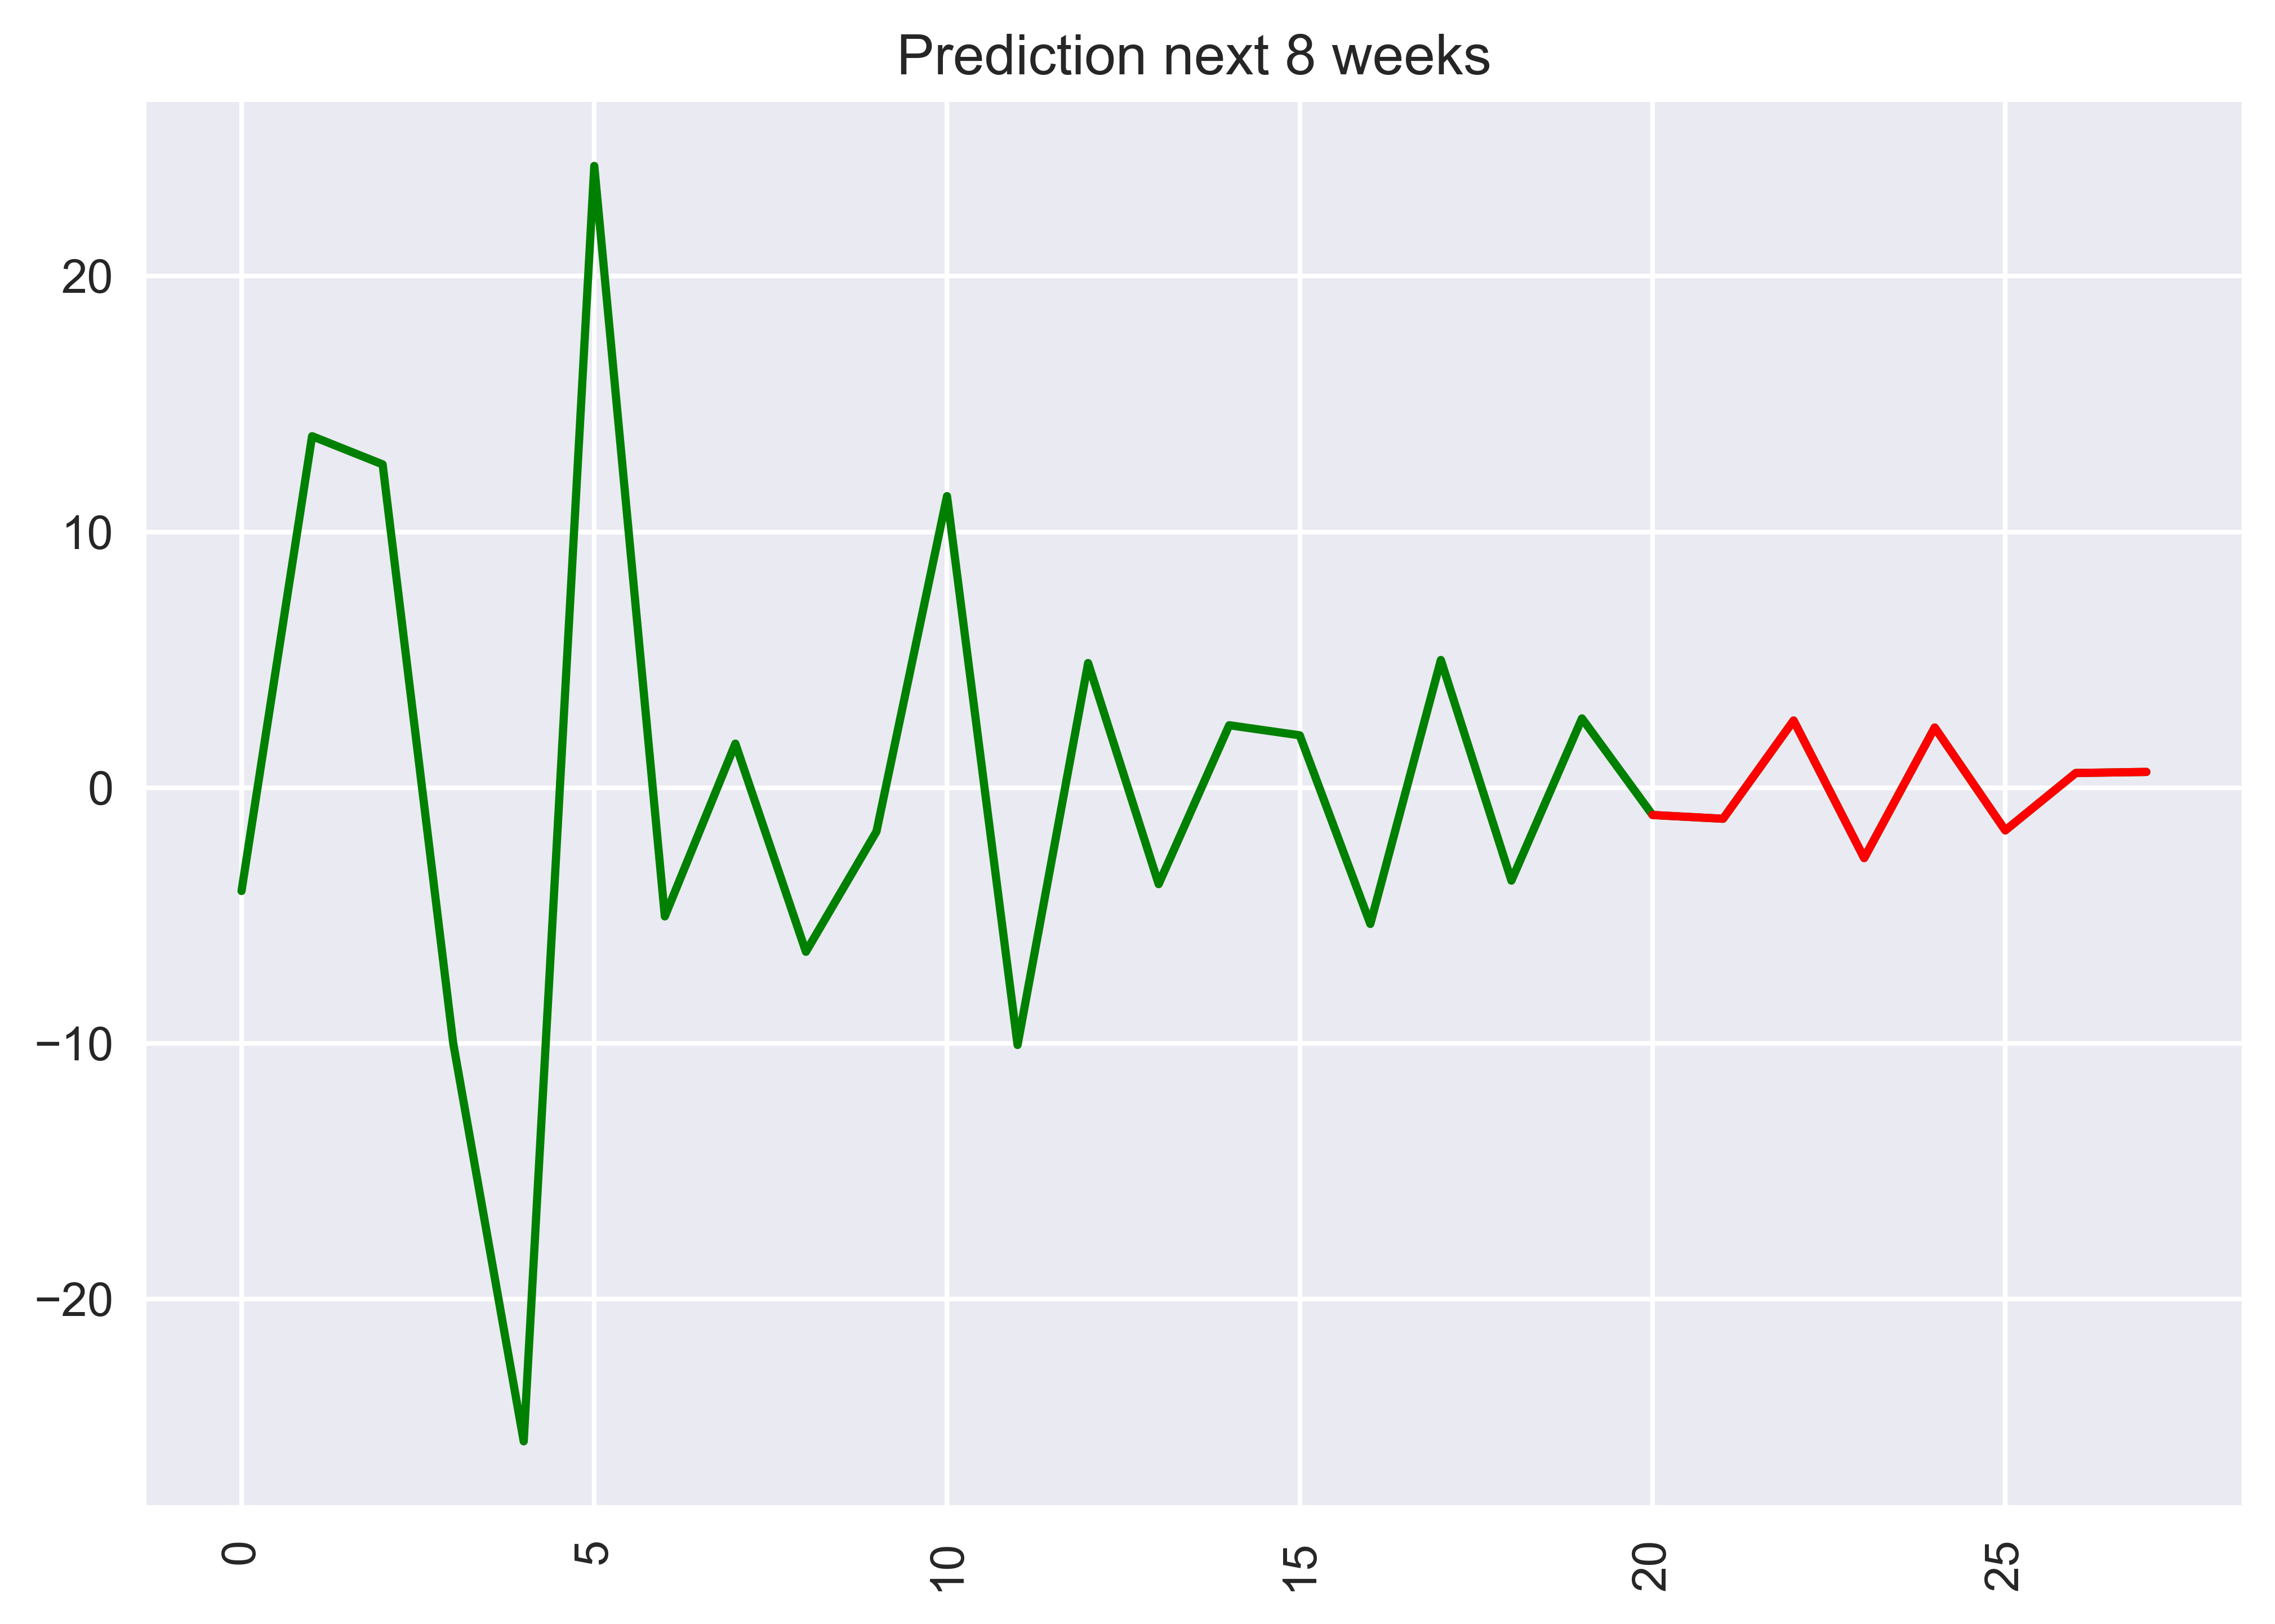

In [37]:
forecast = model.predict(n_periods=len(test)+8)
plt.plot(np.arange(28), forecast, color='green')
plt.plot(np.array([20,21,22,23,24,25,26,27]), forecast[len(test):], color='red')
plt.xticks(rotation='vertical')
plt.title('Prediction next 8 weeks')
plt.show()